<a href="https://colab.research.google.com/github/bhyeon1/Haribo_CNN/blob/main/Haribo_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [40]:
import zipfile
import os
from google.colab import drive

# ✅ Google Drive 마운트
drive.mount('/content/drive')

# ✅ 정확한 zip 파일 경로
zip_filename = "/content/drive/MyDrive/Colab Notebooks/haribo_data.zip"

# ✅ 압축 해제할 경로 (Colab 작업 디렉토리에 풀기)
extract_path = "/content/drive/MyDrive/Colab Notebooks"


# ✅ 압축 해제
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료:", extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
압축 해제 완료: /content/drive/MyDrive/Colab Notebooks


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
data_path = '/content/drive/MyDrive/Colab Notebooks/haribo_data'

In [44]:
data_path

'/content/drive/MyDrive/Colab Notebooks/haribo_data'

In [45]:
# 경로 설정
data_dir = '/content/drive/MyDrive/Colab Notebooks/haribo_data'

# 전처리 및 증강
img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 1658 images belonging to 5 classes.
Found 414 images belonging to 5 classes.


In [46]:
# 전이학습 모델 로드 및 일부 층만 fine-tune
base_model = MobileNetV2(input_shape=img_size + (3,),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = True  # 전체 레이어 훈련 가능

# 앞부분은 동결, 뒷부분만 훈련
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [48]:
# 전체 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

In [49]:
# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # 낮은 lr 사용
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
# 학습
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, lr_scheduler],
    verbose=2
)

Epoch 1/30
52/52 - 67s - 1s/step - accuracy: 0.8432 - loss: 0.4988 - val_accuracy: 0.6304 - val_loss: 1.0576 - learning_rate: 1.0000e-04
Epoch 2/30
52/52 - 46s - 885ms/step - accuracy: 0.9885 - loss: 0.0631 - val_accuracy: 0.6449 - val_loss: 1.2319 - learning_rate: 1.0000e-04
Epoch 3/30
52/52 - 46s - 891ms/step - accuracy: 0.9982 - loss: 0.0283 - val_accuracy: 0.7005 - val_loss: 1.0116 - learning_rate: 1.0000e-04
Epoch 4/30
52/52 - 86s - 2s/step - accuracy: 0.9982 - loss: 0.0218 - val_accuracy: 0.6981 - val_loss: 1.0196 - learning_rate: 1.0000e-04
Epoch 5/30
52/52 - 46s - 886ms/step - accuracy: 0.9988 - loss: 0.0175 - val_accuracy: 0.7319 - val_loss: 0.8757 - learning_rate: 1.0000e-04
Epoch 6/30
52/52 - 45s - 874ms/step - accuracy: 0.9976 - loss: 0.0148 - val_accuracy: 0.7343 - val_loss: 0.9114 - learning_rate: 1.0000e-04
Epoch 7/30
52/52 - 47s - 902ms/step - accuracy: 0.9988 - loss: 0.0108 - val_accuracy: 0.7850 - val_loss: 0.7882 - learning_rate: 1.0000e-04
Epoch 8/30
52/52 - 47s - 9

In [34]:
# 평가
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"✅ Fine-tuned Validation Accuracy: {val_acc:.4f}")

✅ Fine-tuned Validation Accuracy: 0.9832


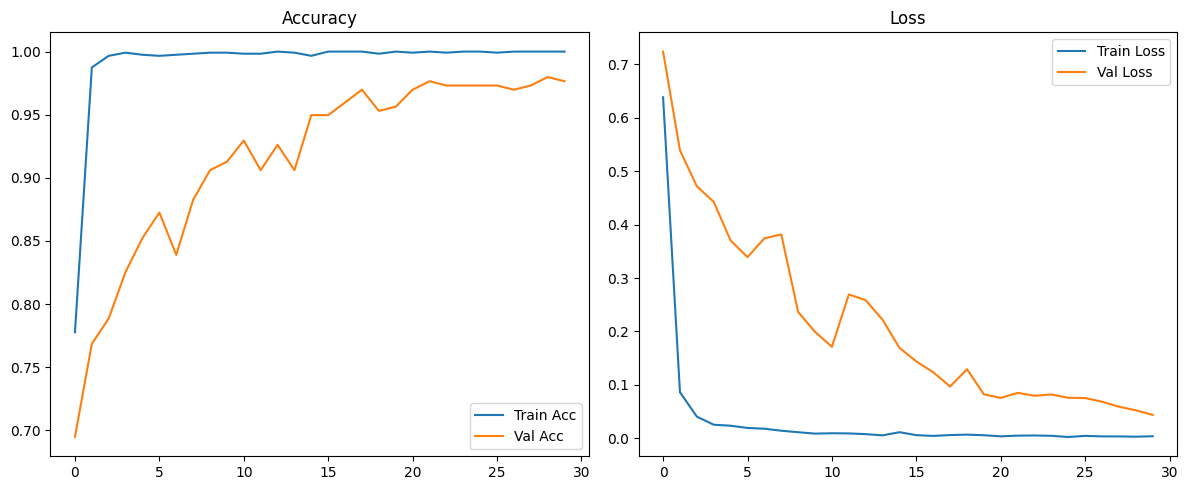

In [35]:
# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
print(train_gen.class_indices)

{'green': 0, 'orange': 1, 'red': 2, 'white': 3, 'yellow': 4}


In [37]:
model.save("haribo_model.h5")

In [38]:
from google.colab import drive
drive.mount("/content/drive")

model.save("/content/drive/MyDrive/haribo_model.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
